In [1]:
from dataset_names.dataset_names import DatasetNames
from attacks.attack_names import AttackNames
from detections.detection_names import DetectionNames
from evaluation.utils import get_output_path

In [2]:
import os
import json
from statistics import fmean, stdev

def get_metrics(base_path):
    if not os.path.exists(base_path):
        raise RuntimeError(f"Path {base_path} does not exist! The experiment has not been conducted yet!")
    TP_list = []
    FP_list = []
    FN_list = []
    Precision_list = []
    Recall_list = []
    malicious_clients_list = []
    detected_clients_list = []
    effectivenesses_list = []
    time_per_iteration_list = []
    final_acc_list = []
    for root, dirs, files in os.walk(base_path):
        relative_path = os.path.relpath(root, base_path)
        path_parts = relative_path.split(os.sep)

        # We expect 2 parts: date, time
        if len(path_parts) >= 2:
            for file_name in files:
                file_path = os.path.join(root, file_name)
                if "Precision_Recall" in file_name:
                    with open(file_path, 'r') as f:
                        precision_recall = json.load(f)
                    TP_list.append(precision_recall["TP"])
                    FP_list.append(precision_recall["FP"])
                    FN_list.append(precision_recall["FN"])
                    Precision_list.append(precision_recall["Precision"])
                    Recall_list.append(precision_recall["Recall"])
                elif "clients" in file_name:
                    with open(file_path, 'r') as f:
                        clients = json.load(f)
                    num_clients = clients["num_clients"]
                    malicious_clients = clients["malicious_clients"]
                    malicious_clients_list.append(malicious_clients)
                    detected_clients_list.append(clients["detected_clients"])
                elif "round_metrics" in file_name:
                    with open(file_path, 'r') as f:
                        round_metrics = json.load(f)
                elif "time" in file_name:
                    with open(file_path, 'r') as f:
                        time = json.load(f)
                    time_per_iteration = time["time_per_iteration"]
                    time_per_iteration_list.append(time_per_iteration)

            if not TP_list:
                # No data found, but directories were created -> the experiment failed because all clients were removed by the detection!
                return {}
            
            # Calculate the Effectiveness of the run
            acc_0 = round_metrics[0]["accuracy"]    # We use the accuracy of the first (0) round.
            acc_n = round_metrics[-1]["accuracy"]
            final_acc_list.append(acc_n)
            clients_done = []
            effectivenesses = []
            for idx, round_metric in enumerate(round_metrics):
                detected_FRs = round_metric["detected_FR"]
                acc_i_1 = round_metrics[idx-1]["accuracy"]  # Get the accuracy of the previous global model.
                if detected_FRs:
                    for det_FR in detected_FRs:
                        # Check whether the FR is malicious and if it has not already been detected in a previous round
                        if det_FR in malicious_clients and det_FR not in clients_done:
                            # In this round, a new FR was detected.
                            # Calculate the Effectiveness for this FR (min-max scaling with respect to the accuracy of the global model)
                            effectiveness = 1 - ((acc_i_1 - acc_0) / (acc_n - acc_0))
                            effectivenesses.append(effectiveness)
                            clients_done.append(det_FR)
            
            not_detected_FR = [cid for cid in malicious_clients if cid not in clients_done]
            for n_d_FR in not_detected_FR:
                effectivenesses.append(0.0)
            effectiveness_all = fmean(effectivenesses) if effectivenesses else 0

            effectivenesses_list.append(effectiveness_all)

    # Check if the experiment failed
    if not TP_list:
        # No data found, but directories were created -> the experiment failed because all clients were removed by the detection!
        return {}

    TP_avg = fmean(TP_list)
    TP_std = stdev(TP_list)
    FP_avg = fmean(FP_list)
    FP_std = stdev(FP_list)
    FN_avg = fmean(FN_list)
    FN_std = fmean(FN_list)
    Precision_avg = fmean(Precision_list)
    Precision_std = stdev(Precision_list)
    Recall_avg = fmean(Recall_list)
    Recall_std = stdev(Recall_list)
    effectiveness_avg = fmean(effectivenesses_list)
    effectiveness_std = stdev(effectivenesses_list)
    time_per_iteration_avg = fmean(time_per_iteration_list)
    time_per_iteration_std = stdev(time_per_iteration_list)
    final_acc_avg = fmean(final_acc_list)
    final_acc_std = stdev(final_acc_list)

    return {
        "TP_avg": TP_avg,
        "TP_std": TP_std,
        "FP_avg": FP_avg,
        "FP_std": FP_std,
        "FN_avg": FN_avg,
        "FN_std": FN_std,
        "Precision_avg": Precision_avg,
        "Precision_std": Precision_std,
        "Recall_avg": Recall_avg,
        "Recall_std": Recall_std,
        "Effectiveness_avg": effectiveness_avg,
        "Effectiveness_std": effectiveness_std,
        "Time_per_iteration_avg": time_per_iteration_avg,
        "Time_per_iteration_std": time_per_iteration_std,
        "Final_acc_avg": final_acc_avg,
        "Final_acc_std": final_acc_std
    }

In [3]:
from typing import List

def format_results(results_dict):
    if len(results_dict) == 0:
        return "FAILED! \n"
    
    CUSTOM_ORDER = [
        "Precision",
        "Recall",
        "Effectiveness",
        "Time_per_iteration",
        "Final_acc",
        "TP",
        "FP",
        "FN"
    ]
    
    # Identify unique metric names by stripping suffixes
    metric_names = set()
   
    for key in results_dict.keys():
        # Strip either '_avg' or '_std' to find the common base name (e.g., 'TP')
        if key.endswith('_avg'):
            metric_names.add(key[:-4])
        elif key.endswith('_std'):
            metric_names.add(key[:-4])

    formatted_lines = []
    # Iterate over the unique metric names (sorted for consistent output)
    for base_name in CUSTOM_ORDER:
        avg_key = f"{base_name}_avg"
        std_key = f"{base_name}_std"

        avg_value = results_dict.get(avg_key, float('nan'))
        std_value = results_dict.get(std_key, float('nan'))
        
        line = f"{avg_key}: {avg_value:.4f} ({std_value:.4f})"
        formatted_lines.append(line)

    return "\n".join(formatted_lines)

def get_experiment_results(dataset: DatasetNames, n_clients: List, perc_malicious: List, attacks: List, detections: List):
    results = {}

    for detection in detections:
        for n_c in n_clients:
            for perc_m in perc_malicious:
                for attack in attacks:
                    path_name = get_output_path(dataset, n_c, perc_m, attack, detection)
                    path = "./outputs/" + path_name
                    metrics = get_metrics(path)
                    results[path_name] = metrics

    for name in results.keys():
        print(f"{name}:\n" 
              "=================================\n" 
              f"{format_results(results[name])}\n")
    return results

#### Note
It is possible that the effectiveness is negative. This can be the case, if acc_i_1 < acc_n, i.e. the accuracy at the last round is slightly worse than e.g. in the penultimate round. Thus, a negative effectiveness indicates an effectiveness of 0.

# Experiment evaluation

## Baseline Runs (no attack, no detection)

### MNIST

In [4]:
dataset = DatasetNames.mnist
n_clients = [10, 100]
perc_malicious = [0]
attacks = [AttackNames.no_attack]
detections = [DetectionNames.no_detection]

results = get_experiment_results(dataset, n_clients, perc_malicious, attacks, detections)

mnist--n=10--0%--no_attack--no_detection:
Precision_avg: 0.0000 (0.0000)
Recall_avg: 0.0000 (0.0000)
Effectiveness_avg: 0.0000 (0.0000)
Time_per_iteration_avg: 3.5076 (0.0277)
Final_acc_avg: 0.9871 (0.0019)
TP_avg: 0.0000 (0.0000)
FP_avg: 0.0000 (0.0000)
FN_avg: 0.0000 (0.0000)

mnist--n=100--0%--no_attack--no_detection:
Precision_avg: 0.0000 (0.0000)
Recall_avg: 0.0000 (0.0000)
Effectiveness_avg: 0.0000 (0.0000)
Time_per_iteration_avg: 3.2186 (0.0473)
Final_acc_avg: 0.9343 (0.0026)
TP_avg: 0.0000 (0.0000)
FP_avg: 0.0000 (0.0000)
FN_avg: 0.0000 (0.0000)



### CIFAR10

In [5]:
dataset = DatasetNames.cifar10
n_clients = [10, 100]
perc_malicious = [0]
attacks = [AttackNames.no_attack]
detections = [DetectionNames.no_detection]

results = get_experiment_results(dataset, n_clients, perc_malicious, attacks, detections)

cifar10--n=10--0%--no_attack--no_detection:
Precision_avg: 0.0000 (0.0000)
Recall_avg: 0.0000 (0.0000)
Effectiveness_avg: 0.0000 (0.0000)
Time_per_iteration_avg: 17.4480 (0.1118)
Final_acc_avg: 0.8078 (0.0031)
TP_avg: 0.0000 (0.0000)
FP_avg: 0.0000 (0.0000)
FN_avg: 0.0000 (0.0000)

cifar10--n=100--0%--no_attack--no_detection:
Precision_avg: 0.0000 (0.0000)
Recall_avg: 0.0000 (0.0000)
Effectiveness_avg: 0.0000 (0.0000)
Time_per_iteration_avg: 21.9924 (0.0717)
Final_acc_avg: 0.7122 (0.0034)
TP_avg: 0.0000 (0.0000)
FP_avg: 0.0000 (0.0000)
FN_avg: 0.0000 (0.0000)



## Comparison Runs (Attacks, no detections)

### MNIST

In [6]:
dataset = DatasetNames.mnist
n_clients = [10, 100]
perc_malicious = [30]
attacks = [AttackNames.random_weights_attack, AttackNames.advanced_delta_weights_attack, AttackNames.advanced_free_rider_attack, AttackNames.adaptive_attack]
detections = [DetectionNames.no_detection]

results = get_experiment_results(dataset, n_clients, perc_malicious, attacks, detections)

mnist--n=10--30%--random_weights--no_detection:
Precision_avg: 0.0000 (0.0000)
Recall_avg: 0.0000 (0.0000)
Effectiveness_avg: 0.0000 (0.0000)
Time_per_iteration_avg: 3.2915 (0.0632)
Final_acc_avg: 0.9202 (0.0004)
TP_avg: 0.0000 (0.0000)
FP_avg: 0.0000 (0.0000)
FN_avg: 3.0000 (3.0000)

mnist--n=10--30%--advanced_delta_weights--no_detection:
Precision_avg: 0.0000 (0.0000)
Recall_avg: 0.0000 (0.0000)
Effectiveness_avg: 0.0000 (0.0000)
Time_per_iteration_avg: 3.3317 (0.0260)
Final_acc_avg: 0.9847 (0.0009)
TP_avg: 0.0000 (0.0000)
FP_avg: 0.0000 (0.0000)
FN_avg: 3.0000 (3.0000)

mnist--n=10--30%--advanced_free_rider--no_detection:
Precision_avg: 0.0000 (0.0000)
Recall_avg: 0.0000 (0.0000)
Effectiveness_avg: 0.0000 (0.0000)
Time_per_iteration_avg: 3.3530 (0.0250)
Final_acc_avg: 0.9841 (0.0008)
TP_avg: 0.0000 (0.0000)
FP_avg: 0.0000 (0.0000)
FN_avg: 3.0000 (3.0000)

mnist--n=10--30%--adaptive--no_detection:
Precision_avg: 0.0000 (0.0000)
Recall_avg: 0.0000 (0.0000)
Effectiveness_avg: 0.0000 (0

### CIFAR10

In [7]:
dataset = DatasetNames.cifar10
n_clients = [10, 100]
perc_malicious = [30]
attacks = [AttackNames.random_weights_attack, AttackNames.advanced_delta_weights_attack, AttackNames.advanced_free_rider_attack, AttackNames.adaptive_attack]
detections = [DetectionNames.no_detection]

results = get_experiment_results(dataset, n_clients, perc_malicious, attacks, detections)

cifar10--n=10--30%--random_weights--no_detection:
Precision_avg: 0.0000 (0.0000)
Recall_avg: 0.0000 (0.0000)
Effectiveness_avg: 0.0000 (0.0000)
Time_per_iteration_avg: 13.6957 (0.1164)
Final_acc_avg: 0.1621 (0.0141)
TP_avg: 0.0000 (0.0000)
FP_avg: 0.0000 (0.0000)
FN_avg: 3.0000 (3.0000)

cifar10--n=10--30%--advanced_delta_weights--no_detection:
Precision_avg: 0.0000 (0.0000)
Recall_avg: 0.0000 (0.0000)
Effectiveness_avg: 0.0000 (0.0000)
Time_per_iteration_avg: 14.2071 (0.0193)
Final_acc_avg: 0.7827 (0.0014)
TP_avg: 0.0000 (0.0000)
FP_avg: 0.0000 (0.0000)
FN_avg: 3.0000 (3.0000)

cifar10--n=10--30%--advanced_free_rider--no_detection:
Precision_avg: 0.0000 (0.0000)
Recall_avg: 0.0000 (0.0000)
Effectiveness_avg: 0.0000 (0.0000)
Time_per_iteration_avg: 14.4727 (0.0422)
Final_acc_avg: 0.6746 (0.0069)
TP_avg: 0.0000 (0.0000)
FP_avg: 0.0000 (0.0000)
FN_avg: 3.0000 (3.0000)

cifar10--n=10--30%--adaptive--no_detection:
Precision_avg: 0.0000 (0.0000)
Recall_avg: 0.0000 (0.0000)
Effectiveness_avg

## Control Runs (Detections, no attacks)

### MNIST

In [8]:
dataset = DatasetNames.mnist
n_clients = [10]
perc_malicious = [0]
attacks = [AttackNames.no_attack]
detections = [DetectionNames.delta_dagmm_detection, DetectionNames.rffl_detection, DetectionNames.fgfl_detection, DetectionNames.viceroy_detection, DetectionNames.wef_detection]

results = get_experiment_results(dataset, n_clients, perc_malicious, attacks, detections)

mnist--n=10--0%--no_attack--delta_dagmm:
Precision_avg: 0.0000 (0.0000)
Recall_avg: 0.0000 (0.0000)
Effectiveness_avg: 0.0000 (0.0000)
Time_per_iteration_avg: 3.5490 (0.0227)
Final_acc_avg: 0.9871 (0.0008)
TP_avg: 0.0000 (0.0000)
FP_avg: 0.0000 (0.0000)
FN_avg: 0.0000 (0.0000)

mnist--n=10--0%--no_attack--rffl:
Precision_avg: 0.0000 (0.0000)
Recall_avg: 0.0000 (0.0000)
Effectiveness_avg: 0.0000 (0.0000)
Time_per_iteration_avg: 3.5711 (0.0281)
Final_acc_avg: 0.9860 (0.0003)
TP_avg: 0.0000 (0.0000)
FP_avg: 0.0000 (0.0000)
FN_avg: 0.0000 (0.0000)

mnist--n=10--0%--no_attack--fgfl:
Precision_avg: 0.0000 (0.0000)
Recall_avg: 0.0000 (0.0000)
Effectiveness_avg: 0.0000 (0.0000)
Time_per_iteration_avg: 3.0892 (0.1289)
Final_acc_avg: 0.9836 (0.0008)
TP_avg: 0.0000 (0.0000)
FP_avg: 5.3333 (1.1547)
FN_avg: 0.0000 (0.0000)

mnist--n=10--0%--no_attack--viceroy:
Precision_avg: 0.0000 (0.0000)
Recall_avg: 0.0000 (0.0000)
Effectiveness_avg: 0.0000 (0.0000)
Time_per_iteration_avg: 3.3866 (0.1014)
Final_

In [9]:
dataset = DatasetNames.mnist
n_clients = [100]
perc_malicious = [0]
attacks = [AttackNames.no_attack]
detections = [DetectionNames.delta_dagmm_detection, DetectionNames.rffl_detection, DetectionNames.fgfl_detection, DetectionNames.viceroy_detection, DetectionNames.wef_detection]

results = get_experiment_results(dataset, n_clients, perc_malicious, attacks, detections)

mnist--n=100--0%--no_attack--delta_dagmm:
Precision_avg: 0.0000 (0.0000)
Recall_avg: 0.0000 (0.0000)
Effectiveness_avg: 0.0000 (0.0000)
Time_per_iteration_avg: 3.2171 (0.1084)
Final_acc_avg: 0.9319 (0.0024)
TP_avg: 0.0000 (0.0000)
FP_avg: 2.6667 (1.5275)
FN_avg: 0.0000 (0.0000)

mnist--n=100--0%--no_attack--rffl:
Precision_avg: 0.0000 (0.0000)
Recall_avg: 0.0000 (0.0000)
Effectiveness_avg: 0.0000 (0.0000)
Time_per_iteration_avg: 3.2104 (0.0072)
Final_acc_avg: 0.9304 (0.0029)
TP_avg: 0.0000 (0.0000)
FP_avg: 0.0000 (0.0000)
FN_avg: 0.0000 (0.0000)

mnist--n=100--0%--no_attack--fgfl:
Precision_avg: 0.0000 (0.0000)
Recall_avg: 0.0000 (0.0000)
Effectiveness_avg: 0.0000 (0.0000)
Time_per_iteration_avg: 2.8988 (0.0298)
Final_acc_avg: 0.9294 (0.0013)
TP_avg: 0.0000 (0.0000)
FP_avg: 24.3333 (2.0817)
FN_avg: 0.0000 (0.0000)

mnist--n=100--0%--no_attack--viceroy:
Precision_avg: 0.0000 (0.0000)
Recall_avg: 0.0000 (0.0000)
Effectiveness_avg: 0.0000 (0.0000)
Time_per_iteration_avg: 3.2742 (0.3134)
F

### CIFAR10

In [10]:
dataset = DatasetNames.cifar10
n_clients = [10]
perc_malicious = [0]
attacks = [AttackNames.no_attack]
detections = [DetectionNames.delta_dagmm_detection, DetectionNames.rffl_detection, DetectionNames.fgfl_detection, DetectionNames.viceroy_detection, DetectionNames.wef_detection]

results = get_experiment_results(dataset, n_clients, perc_malicious, attacks, detections)

cifar10--n=10--0%--no_attack--delta_dagmm:
Precision_avg: 0.0000 (0.0000)
Recall_avg: 0.0000 (0.0000)
Effectiveness_avg: 0.0000 (0.0000)
Time_per_iteration_avg: 17.3557 (0.0117)
Final_acc_avg: 0.8078 (0.0003)
TP_avg: 0.0000 (0.0000)
FP_avg: 0.0000 (0.0000)
FN_avg: 0.0000 (0.0000)

cifar10--n=10--0%--no_attack--rffl:
Precision_avg: 0.0000 (0.0000)
Recall_avg: 0.0000 (0.0000)
Effectiveness_avg: 0.0000 (0.0000)
Time_per_iteration_avg: 17.7242 (0.0155)
Final_acc_avg: 0.8044 (0.0010)
TP_avg: 0.0000 (0.0000)
FP_avg: 0.0000 (0.0000)
FN_avg: 0.0000 (0.0000)

cifar10--n=10--0%--no_attack--fgfl:
Precision_avg: 0.0000 (0.0000)
Recall_avg: 0.0000 (0.0000)
Effectiveness_avg: 0.0000 (0.0000)
Time_per_iteration_avg: 17.2414 (0.3309)
Final_acc_avg: 0.8051 (0.0086)
TP_avg: 0.0000 (0.0000)
FP_avg: 0.3333 (0.5774)
FN_avg: 0.0000 (0.0000)

cifar10--n=10--0%--no_attack--viceroy:
Precision_avg: 0.0000 (0.0000)
Recall_avg: 0.0000 (0.0000)
Effectiveness_avg: 0.0000 (0.0000)
Time_per_iteration_avg: 18.2879 (0.

In [11]:
dataset = DatasetNames.cifar10
n_clients = [100]
perc_malicious = [0]
attacks = [AttackNames.no_attack]
detections = [DetectionNames.delta_dagmm_detection, DetectionNames.rffl_detection, DetectionNames.fgfl_detection, DetectionNames.viceroy_detection, DetectionNames.wef_detection]

results = get_experiment_results(dataset, n_clients, perc_malicious, attacks, detections)

cifar10--n=100--0%--no_attack--delta_dagmm:
Precision_avg: 0.0000 (0.0000)
Recall_avg: 0.0000 (0.0000)
Effectiveness_avg: 0.0000 (0.0000)
Time_per_iteration_avg: 21.6597 (0.1864)
Final_acc_avg: 0.7109 (0.0026)
TP_avg: 0.0000 (0.0000)
FP_avg: 1.0000 (1.0000)
FN_avg: 0.0000 (0.0000)

cifar10--n=100--0%--no_attack--rffl:
Precision_avg: 0.0000 (0.0000)
Recall_avg: 0.0000 (0.0000)
Effectiveness_avg: 0.0000 (0.0000)
Time_per_iteration_avg: 24.0818 (0.1175)
Final_acc_avg: 0.7069 (0.0007)
TP_avg: 0.0000 (0.0000)
FP_avg: 0.0000 (0.0000)
FN_avg: 0.0000 (0.0000)

cifar10--n=100--0%--no_attack--fgfl:
Precision_avg: 0.0000 (0.0000)
Recall_avg: 0.0000 (0.0000)
Effectiveness_avg: 0.0000 (0.0000)
Time_per_iteration_avg: 19.4921 (0.3116)
Final_acc_avg: 0.7035 (0.0021)
TP_avg: 0.0000 (0.0000)
FP_avg: 19.3333 (3.2146)
FN_avg: 0.0000 (0.0000)

cifar10--n=100--0%--no_attack--viceroy:
Precision_avg: 0.0000 (0.0000)
Recall_avg: 0.0000 (0.0000)
Effectiveness_avg: 0.0000 (0.0000)
Time_per_iteration_avg: 35.243

## Benchmark Runs

### MNIST

#### n=10, 10%

In [12]:
dataset = DatasetNames.mnist
n_clients = [10]
perc_malicious = [10]
attacks = [AttackNames.random_weights_attack, AttackNames.advanced_delta_weights_attack, AttackNames.advanced_free_rider_attack, AttackNames.adaptive_attack]
detections = [DetectionNames.delta_dagmm_detection, DetectionNames.rffl_detection, DetectionNames.fgfl_detection, DetectionNames.viceroy_detection, DetectionNames.wef_detection]

results = get_experiment_results(dataset, n_clients, perc_malicious, attacks, detections)

mnist--n=10--10%--random_weights--delta_dagmm:
Precision_avg: 0.8333 (0.2887)
Recall_avg: 1.0000 (0.0000)
Effectiveness_avg: 0.0790 (0.0018)
Time_per_iteration_avg: 3.3589 (0.0542)
Final_acc_avg: 0.9867 (0.0008)
TP_avg: 1.0000 (0.0000)
FP_avg: 0.3333 (0.5774)
FN_avg: 0.0000 (0.0000)

mnist--n=10--10%--advanced_delta_weights--delta_dagmm:
Precision_avg: 1.0000 (0.0000)
Recall_avg: 1.0000 (0.0000)
Effectiveness_avg: 0.0073 (0.0009)
Time_per_iteration_avg: 3.3845 (0.0050)
Final_acc_avg: 0.9861 (0.0007)
TP_avg: 1.0000 (0.0000)
FP_avg: 0.0000 (0.0000)
FN_avg: 0.0000 (0.0000)

mnist--n=10--10%--advanced_free_rider--delta_dagmm:
Precision_avg: 1.0000 (0.0000)
Recall_avg: 1.0000 (0.0000)
Effectiveness_avg: 0.0096 (0.0008)
Time_per_iteration_avg: 3.4330 (0.0463)
Final_acc_avg: 0.9862 (0.0003)
TP_avg: 1.0000 (0.0000)
FP_avg: 0.0000 (0.0000)
FN_avg: 0.0000 (0.0000)

mnist--n=10--10%--adaptive--delta_dagmm:
Precision_avg: 1.0000 (0.0000)
Recall_avg: 1.0000 (0.0000)
Effectiveness_avg: 0.0070 (0.000

#### n=10, 30%

In [13]:
dataset = DatasetNames.mnist
n_clients = [10]
perc_malicious = [30]
attacks = [AttackNames.random_weights_attack, AttackNames.advanced_delta_weights_attack, AttackNames.advanced_free_rider_attack, AttackNames.adaptive_attack]
detections = [DetectionNames.delta_dagmm_detection, DetectionNames.rffl_detection, DetectionNames.fgfl_detection, DetectionNames.viceroy_detection, DetectionNames.wef_detection]

results = get_experiment_results(dataset, n_clients, perc_malicious, attacks, detections)

mnist--n=10--30%--random_weights--delta_dagmm:
Precision_avg: 0.7143 (0.4041)
Recall_avg: 1.0000 (0.0000)
Effectiveness_avg: 0.0918 (0.0002)
Time_per_iteration_avg: 2.8367 (0.4566)
Final_acc_avg: 0.9789 (0.0079)
TP_avg: 3.0000 (0.0000)
FP_avg: 2.0000 (2.8284)
FN_avg: 0.0000 (0.0000)

mnist--n=10--30%--advanced_delta_weights--delta_dagmm:
Precision_avg: 1.0000 (0.0000)
Recall_avg: 1.0000 (0.0000)
Effectiveness_avg: 0.0086 (0.0023)
Time_per_iteration_avg: 3.2159 (0.0293)
Final_acc_avg: 0.9833 (0.0015)
TP_avg: 3.0000 (0.0000)
FP_avg: 0.0000 (0.0000)
FN_avg: 0.0000 (0.0000)

mnist--n=10--30%--advanced_free_rider--delta_dagmm:
Precision_avg: 1.0000 (0.0000)
Recall_avg: 1.0000 (0.0000)
Effectiveness_avg: 0.0170 (0.0148)
Time_per_iteration_avg: 3.2374 (0.0555)
Final_acc_avg: 0.9844 (0.0019)
TP_avg: 3.0000 (0.0000)
FP_avg: 0.0000 (0.0000)
FN_avg: 0.0000 (0.0000)

mnist--n=10--30%--adaptive--delta_dagmm:
Precision_avg: 1.0000 (0.0000)
Recall_avg: 1.0000 (0.0000)
Effectiveness_avg: 0.0362 (0.051

#### n=10, 70%

In [14]:
dataset = DatasetNames.mnist
n_clients = [10]
perc_malicious = [70]
attacks = [AttackNames.random_weights_attack, AttackNames.advanced_delta_weights_attack, AttackNames.advanced_free_rider_attack, AttackNames.adaptive_attack]
detections = [DetectionNames.delta_dagmm_detection, DetectionNames.rffl_detection, DetectionNames.fgfl_detection, DetectionNames.viceroy_detection, DetectionNames.wef_detection]

results = get_experiment_results(dataset, n_clients, perc_malicious, attacks, detections)

mnist--n=10--70%--random_weights--delta_dagmm:
Precision_avg: 0.0000 (0.0000)
Recall_avg: 0.0000 (0.0000)
Effectiveness_avg: 0.0000 (0.0000)
Time_per_iteration_avg: 2.4680 (0.0887)
Final_acc_avg: 0.1008 (0.0025)
TP_avg: 0.0000 (0.0000)
FP_avg: 3.0000 (0.0000)
FN_avg: 7.0000 (7.0000)

mnist--n=10--70%--advanced_delta_weights--delta_dagmm:
Precision_avg: 0.6250 (0.5449)
Recall_avg: 0.6667 (0.5774)
Effectiveness_avg: 0.0080 (0.0069)
Time_per_iteration_avg: 2.6887 (0.3534)
Final_acc_avg: 0.9480 (0.0308)
TP_avg: 4.6667 (4.0415)
FP_avg: 1.0000 (1.0000)
FN_avg: 2.3333 (2.3333)

mnist--n=10--70%--advanced_free_rider--delta_dagmm:
Precision_avg: 0.8750 (0.0000)
Recall_avg: 1.0000 (0.0000)
Effectiveness_avg: 0.0908 (0.0071)
Time_per_iteration_avg: 2.8101 (0.2617)
Final_acc_avg: 0.9674 (0.0055)
TP_avg: 7.0000 (0.0000)
FP_avg: 1.0000 (0.0000)
FN_avg: 0.0000 (0.0000)

mnist--n=10--70%--adaptive--delta_dagmm:
Precision_avg: 0.6250 (0.5449)
Recall_avg: 0.6667 (0.5774)
Effectiveness_avg: 0.0089 (0.007

#### n=100, 10%

In [15]:
dataset = DatasetNames.mnist
n_clients = [100]
perc_malicious = [10]
attacks = [AttackNames.random_weights_attack, AttackNames.advanced_delta_weights_attack, AttackNames.advanced_free_rider_attack, AttackNames.adaptive_attack]
detections = [DetectionNames.delta_dagmm_detection, DetectionNames.rffl_detection, DetectionNames.fgfl_detection, DetectionNames.viceroy_detection, DetectionNames.wef_detection]

results = get_experiment_results(dataset, n_clients, perc_malicious, attacks, detections)

mnist--n=100--10%--random_weights--delta_dagmm:
Precision_avg: 0.7495 (0.1453)
Recall_avg: 1.0000 (0.0000)
Effectiveness_avg: 0.2387 (0.0423)
Time_per_iteration_avg: 2.9834 (0.0284)
Final_acc_avg: 0.9298 (0.0018)
TP_avg: 10.0000 (0.0000)
FP_avg: 3.6667 (2.5166)
FN_avg: 0.0000 (0.0000)

mnist--n=100--10%--advanced_delta_weights--delta_dagmm:
Precision_avg: 0.9091 (0.0000)
Recall_avg: 1.0000 (0.0000)
Effectiveness_avg: 0.0271 (0.0026)
Time_per_iteration_avg: 3.0401 (0.0260)
Final_acc_avg: 0.9322 (0.0044)
TP_avg: 10.0000 (0.0000)
FP_avg: 1.0000 (0.0000)
FN_avg: 0.0000 (0.0000)

mnist--n=100--10%--advanced_free_rider--delta_dagmm:
Precision_avg: 0.7633 (0.1284)
Recall_avg: 1.0000 (0.0000)
Effectiveness_avg: 0.0370 (0.0027)
Time_per_iteration_avg: 3.0735 (0.0354)
Final_acc_avg: 0.9303 (0.0009)
TP_avg: 10.0000 (0.0000)
FP_avg: 3.3333 (2.0817)
FN_avg: 0.0000 (0.0000)

mnist--n=100--10%--adaptive--delta_dagmm:
Precision_avg: 0.7937 (0.0687)
Recall_avg: 1.0000 (0.0000)
Effectiveness_avg: 0.0292

#### n=100, 30%

In [16]:
dataset = DatasetNames.mnist
n_clients = [100]
perc_malicious = [30]
attacks = [AttackNames.random_weights_attack, AttackNames.advanced_delta_weights_attack, AttackNames.advanced_free_rider_attack, AttackNames.adaptive_attack]
detections = [DetectionNames.delta_dagmm_detection, DetectionNames.rffl_detection, DetectionNames.fgfl_detection, DetectionNames.viceroy_detection, DetectionNames.wef_detection]

results = get_experiment_results(dataset, n_clients, perc_malicious, attacks, detections)

mnist--n=100--30%--random_weights--delta_dagmm:
Precision_avg: 0.8083 (0.0754)
Recall_avg: 1.0000 (0.0000)
Effectiveness_avg: 0.3838 (0.1008)
Time_per_iteration_avg: 2.5704 (0.0728)
Final_acc_avg: 0.9123 (0.0012)
TP_avg: 30.0000 (0.0000)
FP_avg: 7.3333 (3.5119)
FN_avg: 0.0000 (0.0000)

mnist--n=100--30%--advanced_delta_weights--delta_dagmm:
Precision_avg: 0.9292 (0.0433)
Recall_avg: 1.0000 (0.0000)
Effectiveness_avg: 0.0284 (0.0013)
Time_per_iteration_avg: 2.8192 (0.0337)
Final_acc_avg: 0.9315 (0.0020)
TP_avg: 30.0000 (0.0000)
FP_avg: 2.3333 (1.5275)
FN_avg: 0.0000 (0.0000)

mnist--n=100--30%--advanced_free_rider--delta_dagmm:
Precision_avg: 0.9381 (0.0293)
Recall_avg: 1.0000 (0.0000)
Effectiveness_avg: 0.0392 (0.0016)
Time_per_iteration_avg: 2.9173 (0.0385)
Final_acc_avg: 0.9319 (0.0022)
TP_avg: 30.0000 (0.0000)
FP_avg: 2.0000 (1.0000)
FN_avg: 0.0000 (0.0000)

mnist--n=100--30%--adaptive--delta_dagmm:
Precision_avg: 0.9381 (0.0293)
Recall_avg: 1.0000 (0.0000)
Effectiveness_avg: 0.0263

#### n=100, 70%

In [17]:
dataset = DatasetNames.mnist
n_clients = [100]
perc_malicious = [70]
attacks = [AttackNames.random_weights_attack, AttackNames.advanced_delta_weights_attack, AttackNames.advanced_free_rider_attack, AttackNames.adaptive_attack]
detections = [DetectionNames.delta_dagmm_detection, DetectionNames.rffl_detection, DetectionNames.fgfl_detection, DetectionNames.viceroy_detection, DetectionNames.wef_detection]

results = get_experiment_results(dataset, n_clients, perc_malicious, attacks, detections)

mnist--n=100--70%--random_weights--delta_dagmm:
Precision_avg: 0.1111 (0.1925)
Recall_avg: 0.0095 (0.0165)
Effectiveness_avg: -0.1501 (0.2600)
Time_per_iteration_avg: 2.5953 (0.0213)
Final_acc_avg: 0.1126 (0.0122)
TP_avg: 0.6667 (1.1547)
FP_avg: 4.3333 (0.5774)
FN_avg: 69.3333 (69.3333)

mnist--n=100--70%--advanced_delta_weights--delta_dagmm:
Precision_avg: 0.9778 (0.0385)
Recall_avg: 1.0000 (0.0000)
Effectiveness_avg: 0.0354 (0.0004)
Time_per_iteration_avg: 2.5262 (0.0542)
Final_acc_avg: 0.9197 (0.0019)
TP_avg: 70.0000 (0.0000)
FP_avg: 1.6667 (2.8868)
FN_avg: 0.0000 (0.0000)

mnist--n=100--70%--advanced_free_rider--delta_dagmm:
Precision_avg: 0.9860 (0.0139)
Recall_avg: 1.0000 (0.0000)
Effectiveness_avg: 0.1489 (0.0265)
Time_per_iteration_avg: 2.4351 (0.0504)
Final_acc_avg: 0.9241 (0.0018)
TP_avg: 70.0000 (0.0000)
FP_avg: 1.0000 (1.0000)
FN_avg: 0.0000 (0.0000)

mnist--n=100--70%--adaptive--delta_dagmm:
Precision_avg: 0.9953 (0.0081)
Recall_avg: 1.0000 (0.0000)
Effectiveness_avg: 0.03

### CIFAR10

#### n=10, 10%

In [18]:
dataset = DatasetNames.cifar10
n_clients = [10]
perc_malicious = [10]
attacks = [AttackNames.random_weights_attack, AttackNames.advanced_delta_weights_attack, AttackNames.advanced_free_rider_attack, AttackNames.adaptive_attack]
detections = [DetectionNames.delta_dagmm_detection, DetectionNames.rffl_detection, DetectionNames.fgfl_detection, DetectionNames.viceroy_detection, DetectionNames.wef_detection]

results = get_experiment_results(dataset, n_clients, perc_malicious, attacks, detections)

cifar10--n=10--10%--random_weights--delta_dagmm:
Precision_avg: 0.8333 (0.2887)
Recall_avg: 1.0000 (0.0000)
Effectiveness_avg: 0.2583 (0.0020)
Time_per_iteration_avg: 15.7959 (0.2611)
Final_acc_avg: 0.8075 (0.0018)
TP_avg: 1.0000 (0.0000)
FP_avg: 0.3333 (0.5774)
FN_avg: 0.0000 (0.0000)

cifar10--n=10--10%--advanced_delta_weights--delta_dagmm:
Precision_avg: 0.8333 (0.2887)
Recall_avg: 1.0000 (0.0000)
Effectiveness_avg: 0.2325 (0.0174)
Time_per_iteration_avg: 15.8859 (0.4866)
Final_acc_avg: 0.8038 (0.0057)
TP_avg: 1.0000 (0.0000)
FP_avg: 0.3333 (0.5774)
FN_avg: 0.0000 (0.0000)

cifar10--n=10--10%--advanced_free_rider--delta_dagmm:
Precision_avg: 0.8333 (0.2887)
Recall_avg: 1.0000 (0.0000)
Effectiveness_avg: 0.2308 (0.0049)
Time_per_iteration_avg: 15.9497 (0.3136)
Final_acc_avg: 0.8010 (0.0044)
TP_avg: 1.0000 (0.0000)
FP_avg: 0.3333 (0.5774)
FN_avg: 0.0000 (0.0000)

cifar10--n=10--10%--adaptive--delta_dagmm:
Precision_avg: 0.6667 (0.2887)
Recall_avg: 1.0000 (0.0000)
Effectiveness_avg: 0.

#### n=10, 30%

In [19]:
dataset = DatasetNames.cifar10
n_clients = [10]
perc_malicious = [30]
attacks = [AttackNames.random_weights_attack, AttackNames.advanced_delta_weights_attack, AttackNames.advanced_free_rider_attack, AttackNames.adaptive_attack]
detections = [DetectionNames.delta_dagmm_detection, DetectionNames.rffl_detection, DetectionNames.fgfl_detection, DetectionNames.viceroy_detection, DetectionNames.wef_detection]

results = get_experiment_results(dataset, n_clients, perc_malicious, attacks, detections)

cifar10--n=10--30%--random_weights--delta_dagmm:
Precision_avg: 0.6500 (0.0866)
Recall_avg: 1.0000 (0.0000)
Effectiveness_avg: 0.2929 (0.0131)
Time_per_iteration_avg: 12.3976 (0.2747)
Final_acc_avg: 0.7390 (0.0036)
TP_avg: 3.0000 (0.0000)
FP_avg: 1.6667 (0.5774)
FN_avg: 0.0000 (0.0000)

cifar10--n=10--30%--advanced_delta_weights--delta_dagmm:
Precision_avg: 1.0000 (0.0000)
Recall_avg: 1.0000 (0.0000)
Effectiveness_avg: 0.3547 (0.0032)
Time_per_iteration_avg: 13.8886 (0.0632)
Final_acc_avg: 0.7835 (0.0032)
TP_avg: 3.0000 (0.0000)
FP_avg: 0.0000 (0.0000)
FN_avg: 0.0000 (0.0000)

cifar10--n=10--30%--advanced_free_rider--delta_dagmm:
Precision_avg: 0.9167 (0.1443)
Recall_avg: 1.0000 (0.0000)
Effectiveness_avg: 0.3636 (0.0115)
Time_per_iteration_avg: 13.3722 (0.4069)
Final_acc_avg: 0.7838 (0.0070)
TP_avg: 3.0000 (0.0000)
FP_avg: 0.3333 (0.5774)
FN_avg: 0.0000 (0.0000)

cifar10--n=10--30%--adaptive--delta_dagmm:
Precision_avg: 1.0000 (0.0000)
Recall_avg: 1.0000 (0.0000)
Effectiveness_avg: 0.

#### n=10, 70%

In [20]:
dataset = DatasetNames.cifar10
n_clients = [10]
perc_malicious = [70]
attacks = [AttackNames.random_weights_attack, AttackNames.advanced_delta_weights_attack, AttackNames.advanced_free_rider_attack, AttackNames.adaptive_attack]
detections = [DetectionNames.delta_dagmm_detection, DetectionNames.rffl_detection, DetectionNames.fgfl_detection, DetectionNames.viceroy_detection, DetectionNames.wef_detection]

results = get_experiment_results(dataset, n_clients, perc_malicious, attacks, detections)

cifar10--n=10--70%--random_weights--delta_dagmm:
FAILED! 


cifar10--n=10--70%--advanced_delta_weights--delta_dagmm:
Precision_avg: 0.8750 (0.0000)
Recall_avg: 1.0000 (0.0000)
Effectiveness_avg: 0.4562 (0.0176)
Time_per_iteration_avg: 9.7864 (0.2748)
Final_acc_avg: 0.6689 (0.0133)
TP_avg: 7.0000 (0.0000)
FP_avg: 1.0000 (0.0000)
FN_avg: 0.0000 (0.0000)

cifar10--n=10--70%--advanced_free_rider--delta_dagmm:
Precision_avg: 0.9167 (0.0722)
Recall_avg: 1.0000 (0.0000)
Effectiveness_avg: 0.4611 (0.0240)
Time_per_iteration_avg: 9.7420 (0.2737)
Final_acc_avg: 0.6891 (0.0287)
TP_avg: 7.0000 (0.0000)
FP_avg: 0.6667 (0.5774)
FN_avg: 0.0000 (0.0000)

cifar10--n=10--70%--adaptive--delta_dagmm:
Precision_avg: 0.8750 (0.0000)
Recall_avg: 1.0000 (0.0000)
Effectiveness_avg: 0.4323 (0.0029)
Time_per_iteration_avg: 9.8079 (0.1978)
Final_acc_avg: 0.6688 (0.0027)
TP_avg: 7.0000 (0.0000)
FP_avg: 1.0000 (0.0000)
FN_avg: 0.0000 (0.0000)

cifar10--n=10--70%--random_weights--rffl:
Precision_avg: 1.0000 (0.0000)

#### n=100, 10%

In [21]:
dataset = DatasetNames.cifar10
n_clients = [100]
perc_malicious = [10]
attacks = [AttackNames.random_weights_attack, AttackNames.advanced_delta_weights_attack, AttackNames.advanced_free_rider_attack, AttackNames.adaptive_attack]
detections = [DetectionNames.delta_dagmm_detection, DetectionNames.rffl_detection, DetectionNames.fgfl_detection, DetectionNames.viceroy_detection, DetectionNames.wef_detection]

results = get_experiment_results(dataset, n_clients, perc_malicious, attacks, detections)

cifar10--n=100--10%--random_weights--delta_dagmm:
Precision_avg: 0.1068 (0.0007)
Recall_avg: 1.0000 (0.0000)
Effectiveness_avg: 0.0374 (0.0368)
Time_per_iteration_avg: 9.4514 (0.2699)
Final_acc_avg: 0.6601 (0.0209)
TP_avg: 10.0000 (0.0000)
FP_avg: 83.6667 (0.5774)
FN_avg: 0.0000 (0.0000)

cifar10--n=100--10%--advanced_delta_weights--delta_dagmm:
Precision_avg: 0.8838 (0.0437)
Recall_avg: 1.0000 (0.0000)
Effectiveness_avg: 0.2696 (0.0060)
Time_per_iteration_avg: 20.3888 (0.0112)
Final_acc_avg: 0.7123 (0.0038)
TP_avg: 10.0000 (0.0000)
FP_avg: 1.3333 (0.5774)
FN_avg: 0.0000 (0.0000)

cifar10--n=100--10%--advanced_free_rider--delta_dagmm:
Precision_avg: 0.8586 (0.0437)
Recall_avg: 1.0000 (0.0000)
Effectiveness_avg: 0.3162 (0.0055)
Time_per_iteration_avg: 20.4678 (0.1988)
Final_acc_avg: 0.7084 (0.0014)
TP_avg: 10.0000 (0.0000)
FP_avg: 1.6667 (0.5774)
FN_avg: 0.0000 (0.0000)

cifar10--n=100--10%--adaptive--delta_dagmm:
Precision_avg: 0.9091 (0.0000)
Recall_avg: 1.0000 (0.0000)
Effectiveness_

#### n=100, 30%

In [22]:
dataset = DatasetNames.cifar10
n_clients = [100]
perc_malicious = [30]
attacks = [AttackNames.random_weights_attack, AttackNames.advanced_delta_weights_attack, AttackNames.advanced_free_rider_attack, AttackNames.adaptive_attack]
detections = [DetectionNames.delta_dagmm_detection, DetectionNames.rffl_detection, DetectionNames.fgfl_detection, DetectionNames.viceroy_detection, DetectionNames.wef_detection]

results = get_experiment_results(dataset, n_clients, perc_malicious, attacks, detections)

cifar10--n=100--30%--random_weights--delta_dagmm:
Precision_avg: 0.1041 (0.0545)
Recall_avg: 0.2778 (0.1644)
Effectiveness_avg: 2.8860 (9.5032)
Time_per_iteration_avg: 8.6707 (0.2752)
Final_acc_avg: 0.1000 (0.0000)
TP_avg: 8.3333 (4.9329)
FP_avg: 70.0000 (0.0000)
FN_avg: 21.6667 (21.6667)

cifar10--n=100--30%--advanced_delta_weights--delta_dagmm:
Precision_avg: 0.9577 (0.0175)
Recall_avg: 1.0000 (0.0000)
Effectiveness_avg: 0.2540 (0.0021)
Time_per_iteration_avg: 17.5227 (0.0715)
Final_acc_avg: 0.7015 (0.0058)
TP_avg: 30.0000 (0.0000)
FP_avg: 1.3333 (0.5774)
FN_avg: 0.0000 (0.0000)

cifar10--n=100--30%--advanced_free_rider--delta_dagmm:
Precision_avg: 0.9096 (0.0276)
Recall_avg: 1.0000 (0.0000)
Effectiveness_avg: 0.7585 (0.2227)
Time_per_iteration_avg: 18.1464 (0.1190)
Final_acc_avg: 0.1092 (0.0044)
TP_avg: 30.0000 (0.0000)
FP_avg: 3.0000 (1.0000)
FN_avg: 0.0000 (0.0000)

cifar10--n=100--30%--adaptive--delta_dagmm:
Precision_avg: 0.9785 (0.0186)
Recall_avg: 1.0000 (0.0000)
Effectiveness

#### n=100, 70%

In [23]:
dataset = DatasetNames.cifar10
n_clients = [100]
perc_malicious = [70]
attacks = [AttackNames.random_weights_attack, AttackNames.advanced_delta_weights_attack, AttackNames.advanced_free_rider_attack, AttackNames.adaptive_attack]
detections = [DetectionNames.delta_dagmm_detection, DetectionNames.rffl_detection, DetectionNames.fgfl_detection, DetectionNames.viceroy_detection, DetectionNames.wef_detection]

results = get_experiment_results(dataset, n_clients, perc_malicious, attacks, detections)

cifar10--n=100--70%--random_weights--delta_dagmm:
Precision_avg: 0.0000 (0.0000)
Recall_avg: 0.0000 (0.0000)
Effectiveness_avg: 0.0000 (0.0000)
Time_per_iteration_avg: 10.1502 (0.0658)
Final_acc_avg: 0.1000 (0.0000)
TP_avg: 0.0000 (0.0000)
FP_avg: 30.0000 (0.0000)
FN_avg: 70.0000 (70.0000)

cifar10--n=100--70%--advanced_delta_weights--delta_dagmm:
Precision_avg: 1.0000 (0.0000)
Recall_avg: 1.0000 (0.0000)
Effectiveness_avg: 0.2592 (0.0070)
Time_per_iteration_avg: 12.5456 (0.0566)
Final_acc_avg: 0.6743 (0.0016)
TP_avg: 70.0000 (0.0000)
FP_avg: 0.0000 (0.0000)
FN_avg: 0.0000 (0.0000)

cifar10--n=100--70%--advanced_free_rider--delta_dagmm:
Precision_avg: 0.8807 (0.0509)
Recall_avg: 1.0000 (0.0000)
Effectiveness_avg: -0.2009 (1.6365)
Time_per_iteration_avg: 12.2682 (0.7580)
Final_acc_avg: 0.1010 (0.0030)
TP_avg: 70.0000 (0.0000)
FP_avg: 9.6667 (4.7258)
FN_avg: 0.0000 (0.0000)

cifar10--n=100--70%--adaptive--delta_dagmm:
Precision_avg: 1.0000 (0.0000)
Recall_avg: 1.0000 (0.0000)
Effectivene

Confusion Matrix
===

In [24]:
import os
import json
from statistics import fmean, stdev
from typing import List

def get_confusion_metrics(base_path_list: List):
    for base_path in base_path_list:
        if not os.path.exists(base_path):
            raise RuntimeError(f"Path {base_path} does not exist! The experiment has not been conducted yet!")
    
    malicious_clients_set = set()
    detected_clients_set_by_run = dict()
    
    round_metrics = dict()
    assert len(base_path_list) == 2 # Currently only works for 2 detections
    # For each detection
    for base_path in base_path_list:
        # For each run
        run_index = 0
        round_metrics[base_path] = dict()
        for root, dir, files in os.walk(base_path):
            relative_path = os.path.relpath(root, base_path)
            path_parts = relative_path.split(os.sep)

            # We expect 2 parts: date, time
            if len(path_parts) >= 2:
                something_found = False
                for file_name in files:
                    file_path = os.path.join(root, file_name)
                    if "clients" in file_name:
                        with open(file_path, 'r') as f:
                            clients = json.load(f)
                        num_clients = clients["num_clients"]
                        malicious_clients = clients["malicious_clients"]
                        malicious_clients_set.update(set(malicious_clients))

                        if not run_index in detected_clients_set_by_run:
                            detected_clients_set_by_run[run_index] = set()

                        detected_clients = clients["detected_clients"]
                        detected_clients_set_by_run[run_index].update(set(detected_clients))
                        something_found = True
                    elif "round_metrics" in file_name:
                        with open(file_path, 'r') as f:
                            round_metrics[base_path][run_index] = json.load(f)

                if not something_found:
                    # No data found, but directories were created -> the experiment failed because all clients were removed by the detection!
                    return {}
            
                run_index += 1

    # Calculate Effectivenesses
    if len(round_metrics[base_path_list[0]]) == 0 or len(round_metrics[base_path_list[1]]) == 0:
        # One of the two detections failed in every round!
        return {}
    
    min_number_of_runs = min(len(round_metrics[base_path_list[0]]), len(round_metrics[base_path_list[1]]))

    Effectiveness_means_list = []
    for run_i in range(0, min_number_of_runs):
        # Calculate the Effectiveness of the run
        round_metrics_detection_1 = round_metrics[base_path_list[0]][run_i]
        round_metrics_detection_2 = round_metrics[base_path_list[1]][run_i]
        if len(round_metrics_detection_1) != len(round_metrics_detection_2):
            raise IndexError("round_metrics of two detections have differnt length! Different number of rounds??")

        acc_0 = max([round_metrics_detection_1[0]["accuracy"], round_metrics_detection_2[0]["accuracy"]])     # We use the max accuracy of the first (0) rounds.
        acc_n = max([round_metrics_detection_1[-1]["accuracy"], round_metrics_detection_2[-1]["accuracy"]])   # And the max accuracy of the last (-1) rounds.
        
        clients_done = []
        effectivenesses = []
        for idx, _ in enumerate(round_metrics_detection_1):
            detected_FRs_1 = round_metrics_detection_1[idx]["detected_FR"]
            detected_FRs_2 = round_metrics_detection_2[idx]["detected_FR"]
            detected_FRs = set(detected_FRs_1 + detected_FRs_2)
            acc_i_1 = max([round_metrics_detection_1[idx-1]["accuracy"], round_metrics_detection_2[idx-1]["accuracy"]])  # Get the max accuracy of the previous global model.
            if detected_FRs:
                for det_FR in detected_FRs:
                    # Check whether the FR is malicious and if it has not already been detected in a previous round
                    if det_FR in malicious_clients_set and det_FR not in clients_done:
                        # In this round, a new FR was detected.
                        # Calculate the Effectiveness for this FR (min-max scaling with respect to the accuracy of the global model)
                        effectiveness = 1 - ((acc_i_1 - acc_0) / (acc_n - acc_0))
                        if effectiveness < 0:
                            effectiveness = 0.00
                        effectivenesses.append(effectiveness)
                        clients_done.append(det_FR)
            
        not_detected_FR = [cid for cid in malicious_clients_set if cid not in clients_done]
        for n_d_FR in not_detected_FR:
            effectivenesses.append(0.0)
        effectiveness_all = fmean(effectivenesses) if effectivenesses else 0
        Effectiveness_means_list.append(effectiveness_all)

    for i in range(0, 3 - min_number_of_runs):
        # Add an effectiveness of 0 for every run that failed
        Effectiveness_means_list.append(0.0)

    Precision_list = []
    Recall_list = []
    for run_id in detected_clients_set_by_run.keys():
        detected_clients = detected_clients_set_by_run[run_id]

        detected_FR = [id for id in detected_clients if id in malicious_clients_set]
        TP = len(detected_FR)

        detected_BC = [id for id in detected_clients if id not in malicious_clients_set]
        FP = len(detected_BC)

        undetected_FR = [id for id in malicious_clients_set if id not in detected_clients]
        FN = len(undetected_FR)

        Precision = TP / (TP + FP) if TP != 0 else 0
        Recall = TP / (TP + FN) if TP != 0 else 0
        Precision_list.append(Precision)
        Recall_list.append(Recall)

    for i in range(0, 3 - len(detected_clients_set_by_run.keys())):
        Precision_list.append(0.0)
        Recall_list.append(0.0)

    Precision_avg = fmean(Precision_list)
    Precision_std = stdev(Precision_list)
    Recall_avg = fmean(Recall_list)
    Recall_std = stdev(Recall_list)
    Effectiveness_avg = fmean(Effectiveness_means_list)
    Effectiveness_std = stdev(Effectiveness_means_list)

    return {
        "Precision_avg": Precision_avg,
        "Precision_std": Precision_std,
        "Recall_avg": Recall_avg,
        "Recall_std": Recall_std,
        "Effectiveness_avg": Effectiveness_avg,
        "Effectiveness_std": Effectiveness_std
    }

In [25]:
def format_confusion_results(results_dict):
    if len(results_dict) == 0:
        return "FAILED! \n"
    
    CUSTOM_ORDER = [
        "Precision",
        "Recall",
        "Effectiveness"
    ]
    
    # Identify unique metric names by stripping suffixes
    metric_names = set()
   
    for key in results_dict.keys():
        # Strip either '_avg' or '_std' to find the common base name (e.g., 'TP')
        if key.endswith('_avg'):
            metric_names.add(key[:-4])
        elif key.endswith('_std'):
            metric_names.add(key[:-4])

    formatted_lines = []
    # Iterate over the unique metric names (sorted for consistent output)
    for base_name in CUSTOM_ORDER:
        avg_key = f"{base_name}_avg"
        std_key = f"{base_name}_std"

        avg_value = results_dict.get(avg_key, float('nan'))
        std_value = results_dict.get(std_key, float('nan'))
        
        line = f"{avg_key}: {avg_value:.4f} ({std_value:.4f})"
        formatted_lines.append(line)

    return "\n".join(formatted_lines)

def get_confusion_results(dataset: DatasetNames, n_clients, perc_malicious, attack, detections: List, print_result=True):
    results = {}

    path_names = []
    result_index = ""
    for detection in detections:
        path_name = get_output_path(dataset, n_clients, perc_malicious, attack, detection)
        path = "./outputs/" + path_name
        path_names.append(path)
        result_index += path_name + "++++ UNION ++++"
    metrics = get_confusion_metrics(path_names)
    results[result_index] = metrics

    if print_result:
        for name in results.keys():
            print(f"{name}:\n" 
                "=================================\n" 
                f"{format_confusion_results(results[name])}\n")
    
    return results

In [26]:
r = get_confusion_results(DatasetNames.mnist, 100, 70, AttackNames.advanced_free_rider_attack, [DetectionNames.viceroy_detection, DetectionNames.rffl_detection])

mnist--n=100--70%--advanced_free_rider--viceroy++++ UNION ++++mnist--n=100--70%--advanced_free_rider--rffl++++ UNION ++++:
Precision_avg: 0.8907 (0.0342)
Recall_avg: 1.0000 (0.0000)
Effectiveness_avg: 0.3265 (0.0412)



In [27]:
r = get_confusion_results(DatasetNames.mnist, 100, 70, AttackNames.advanced_free_rider_attack, [DetectionNames.viceroy_detection, DetectionNames.viceroy_detection])

mnist--n=100--70%--advanced_free_rider--viceroy++++ UNION ++++mnist--n=100--70%--advanced_free_rider--viceroy++++ UNION ++++:
Precision_avg: 0.8907 (0.0342)
Recall_avg: 1.0000 (0.0000)
Effectiveness_avg: 0.3516 (0.0296)



In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def detection_name_to_presentation_name(detection: DetectionNames):
    match detection:
        case DetectionNames.delta_dagmm_detection:
            return "D-DAG"
        case DetectionNames.rffl_detection:
            return "RFFL"
        case DetectionNames.fgfl_detection:
            return "FGFL"
        case DetectionNames.viceroy_detection:
            return "Viceroy"
        case DetectionNames.wef_detection:
            return "WEF"
        case _:
            return detection.value
    
def attack_name_to_presentation_name(attack: AttackNames):
    match attack:
        case AttackNames.random_weights_attack:
            return "RW"
        case AttackNames.advanced_delta_weights_attack:
            return "ADW"
        case AttackNames.advanced_free_rider_attack:
            return "AdvFR"
        case AttackNames.adaptive_attack:
            return "AdaFR"
        case _:
            return attack.value

all_detections = [DetectionNames.delta_dagmm_detection, DetectionNames.rffl_detection, DetectionNames.fgfl_detection, DetectionNames.viceroy_detection, DetectionNames.wef_detection]
labels = [detection_name_to_presentation_name(method) for method in all_detections]
n = len(all_detections)

def generate_confusion_matrix(g_datasets: List, g_n_clients: List, g_perc_malicious: List, g_attacks: List, isSingleSetting=True):
    def calculate_metrics(detection_1, detection_2):
        # logic to calculate precision/recall for the pair
        prec_list = []
        rec_list = []
        eff_list = []
        for g_n_c in g_n_clients:
            for g_dataset in g_datasets:
                for g_perc in g_perc_malicious:
                    for g_att in g_attacks:
                        results = get_confusion_results(g_dataset, g_n_c, g_perc, g_att, [detection_1, detection_2], print_result=False)
                        result = (next(iter(results.values())))
                        if "Precision_avg" in result:
                            prec = result["Precision_avg"]
                            prec_list.append(prec)
                            rec = result["Recall_avg"]
                            rec_list.append(rec)
                            eff = result["Effectiveness_avg"]
                            eff_list.append(eff)
                        else:
                            # It failed
                            prec_list.append(0.0)
                            rec_list.append(0.0)
                            eff_list.append(0.0)
                
        if len(prec_list) == 1:
            # The function was only called for 1 setting. Return the stdev of exactly this setting
            if "Precision_std" in result:
                # Experiment succeeded
                prec_std_r = result["Precision_std"]
                rec_std_r = result["Recall_std"]
                eff_std_r = result["Effectiveness_std"]
            else:
                # Experiment failed
                return {}
        else:
            prec_std_r = stdev(prec_list)
            rec_std_r = stdev(rec_list)
            eff_std_r = stdev(eff_list)

        result_avg = {
            "Precision_avg": fmean(prec_list),
            "Precision_std": prec_std_r,
            "Recall_avg": fmean(rec_list),
            "Recall_std": rec_std_r,
            "Effectiveness_avg": fmean(eff_list),
            "Effectiveness_std": eff_std_r
        }
        return result_avg

    # 2. Initialize Matrices
    precision_mat = np.zeros((n, n))
    recall_mat = np.zeros((n, n))
    color_mat = np.zeros((n, n)) # Used for the heat color
    annotation_mat = np.empty((n, n), dtype=object)

    # 3. Populate Data
    for i in range(n):
        for j in range(n):
            # Call function to obtain precision and recall
            result = calculate_metrics(all_detections[i], all_detections[j])
            if result:
                prec = result["Precision_avg"]
                prec_std = result["Precision_std"]

                rec = result["Recall_avg"]
                rec_std = result["Recall_std"]

                eff = result["Effectiveness_avg"]
                eff_std = result["Effectiveness_std"]
                
                # Store values
                precision_mat[i, j] = prec
                recall_mat[i, j] = rec
                
                # Calculate F1 for the color gradient (makes the heatmap meaningful)
                f1 = 2 * (prec * rec) / (prec + rec) if (prec + rec) > 0 else 0
                # Scale F1 by effectiveness to obtain the final color value
                f1_scaled_by_eff = f1 * eff
                color_mat[i, j] = f1_scaled_by_eff
                
                # Create the text label for the cell
                annotation_mat[i, j] = f"P: {prec:.2f} ({prec_std:.1f})\nR: {rec:.2f} ({rec_std:.1f})\nE: {eff:.2f} ({eff_std:.1f})"
            else:
                color_mat[i, j] = 0.0
                annotation_mat[i, j] = "failed"

    # 4. Visualization
    plt.figure(figsize=(10, 8))

    # Create the heatmap
    # data=color_mat -> The color intensity is based on the harmonic mean (F1) * effectiveness
    ax = sns.heatmap(color_mat, 
                annot=annotation_mat, 
                fmt="", 
                xticklabels=labels, 
                yticklabels=labels,
                cmap="YlGnBu", # Yellow-Green-Blue colormap
                annot_kws={"fontsize": 14})
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=14)
    cbar.set_label('F1 Score * Effectiveness (Color Intensity)', fontsize=14)

    if isSingleSetting:
        title = "attack=" + attack_name_to_presentation_name(g_attacks[0]) + ", dataset=" + g_datasets[0].value + ", n=" + str(g_n_clients[0]) + ", perc=" + str(g_perc_malicious[0]) + "%"
        path = attack_name_to_presentation_name(g_attacks[0]) + "_" + g_datasets[0].value + "_" + str(g_n_clients[0]) + "_" + str(g_perc_malicious[0])
    else:
        title = "Mean performance accross all settings"
        path = "mean_across_all_settings"
    
    plt.title(title, fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()
    plt.savefig('./evaluation/confusion_matrices/conf_' + path + '.pdf', dpi=300, bbox_inches='tight')
    plt.show()

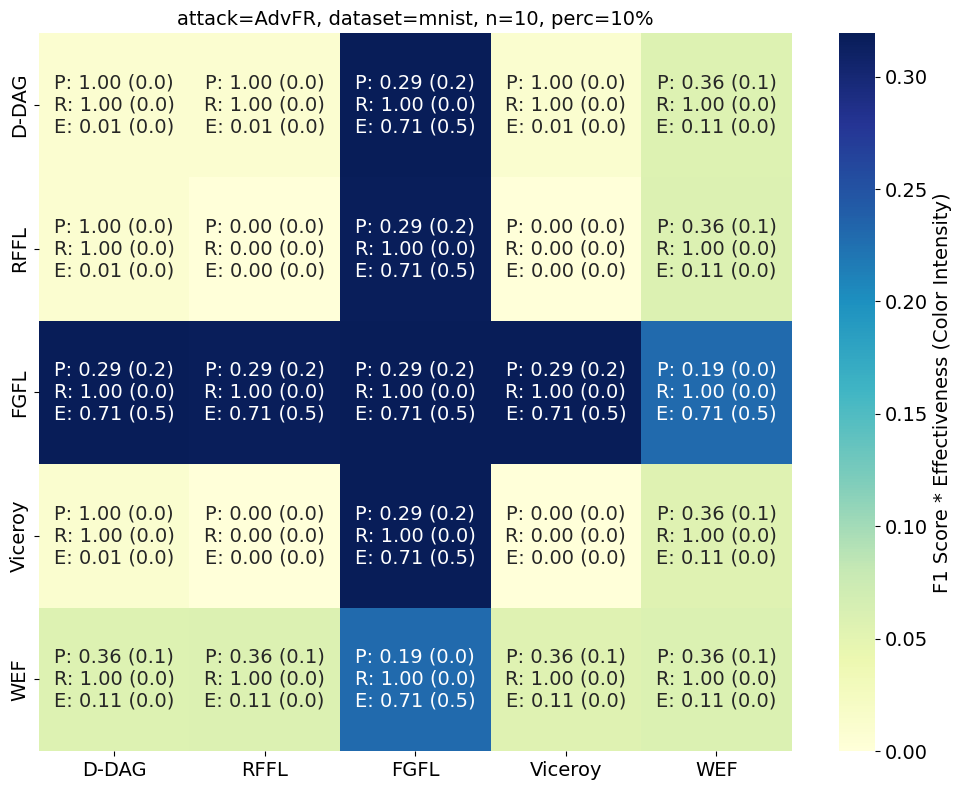

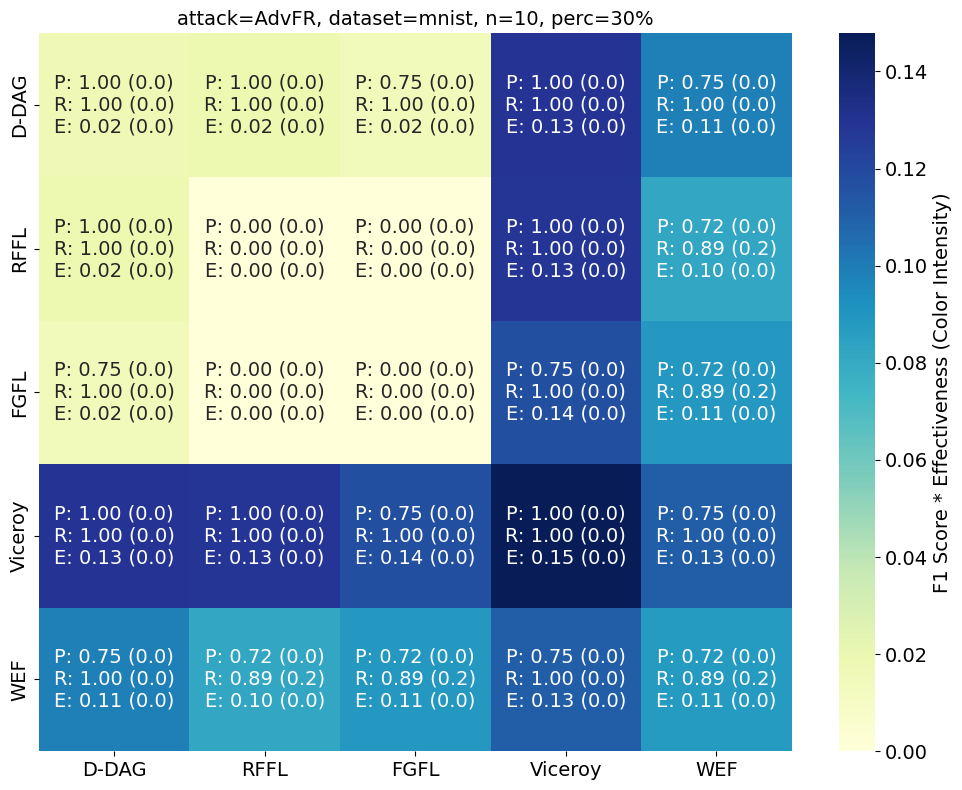

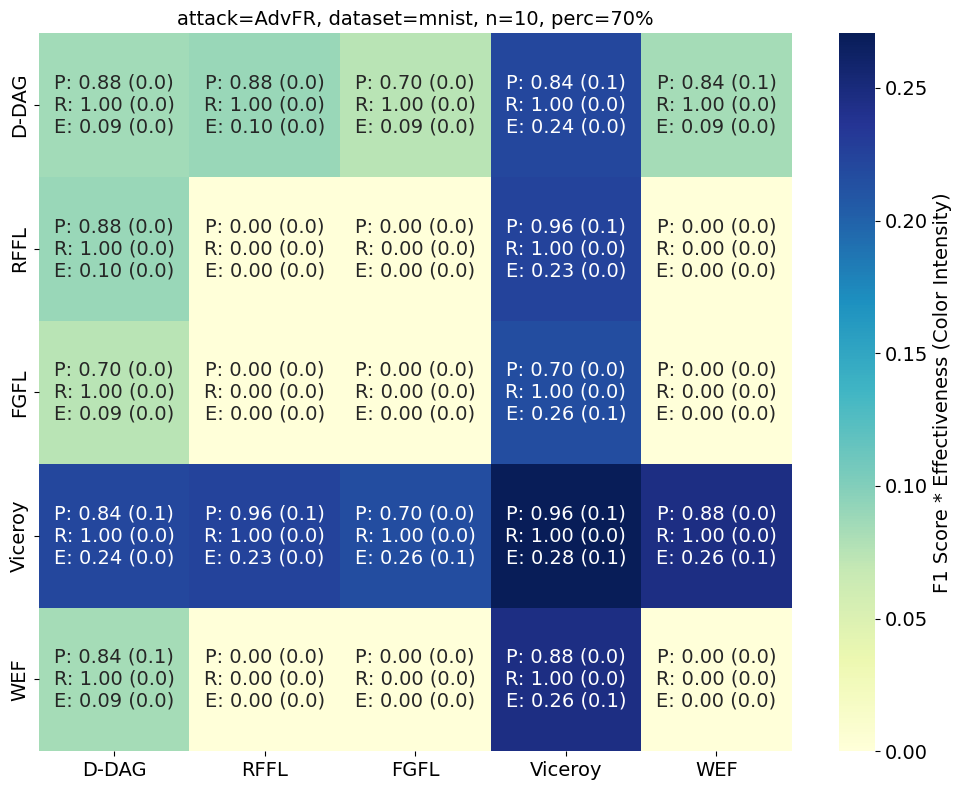

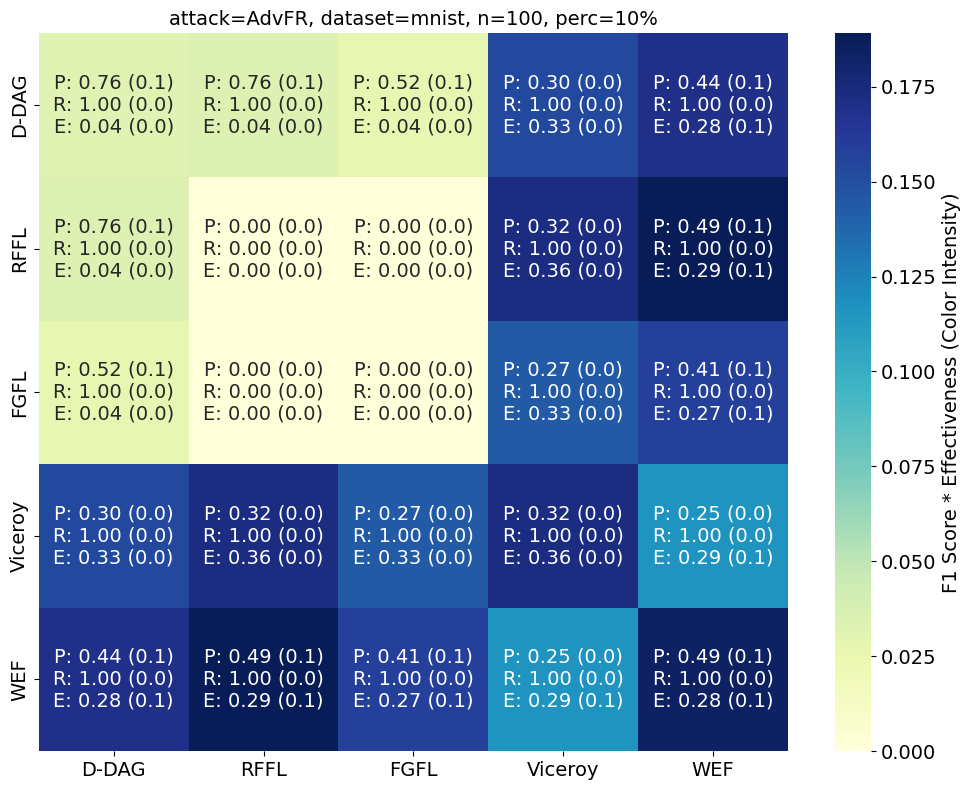

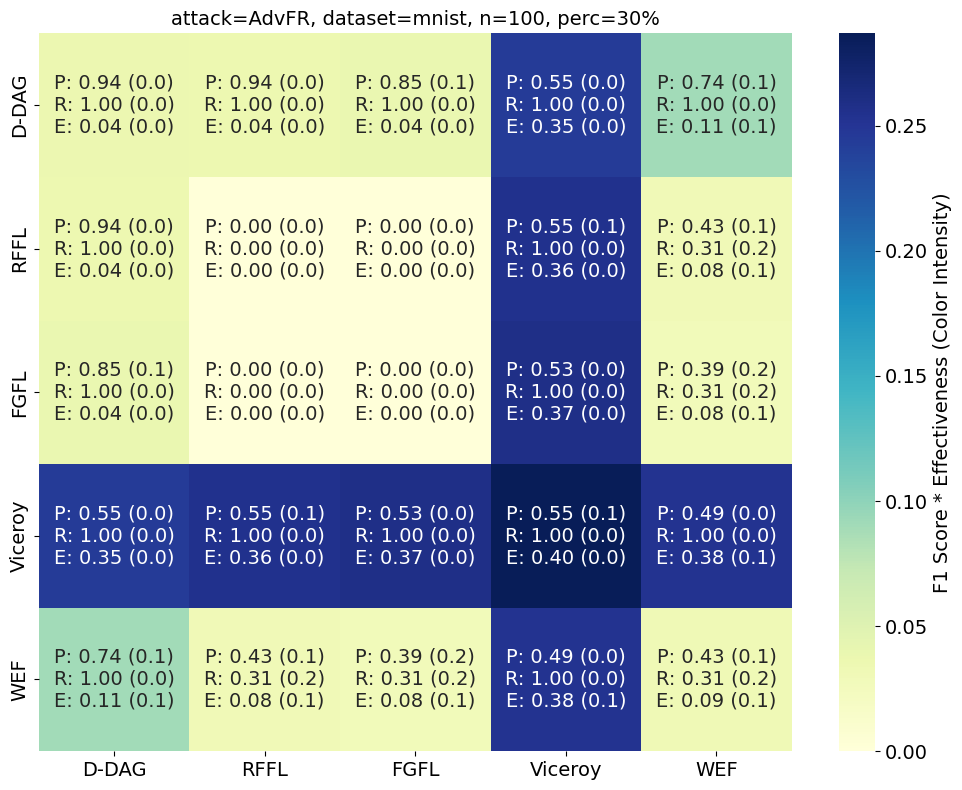

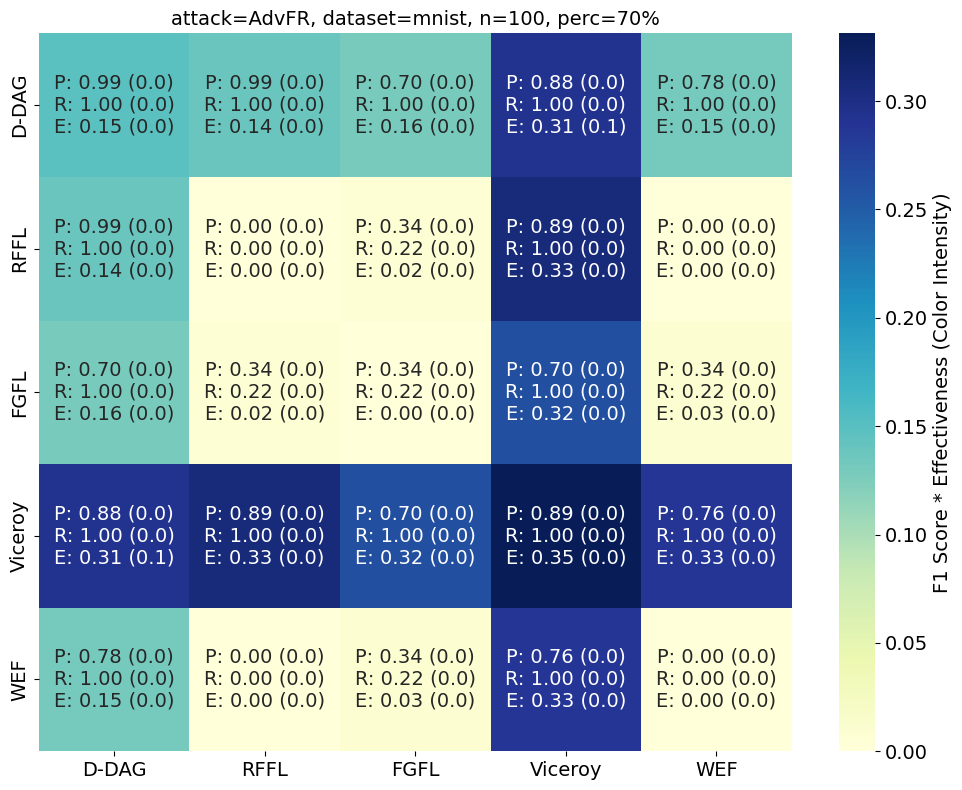

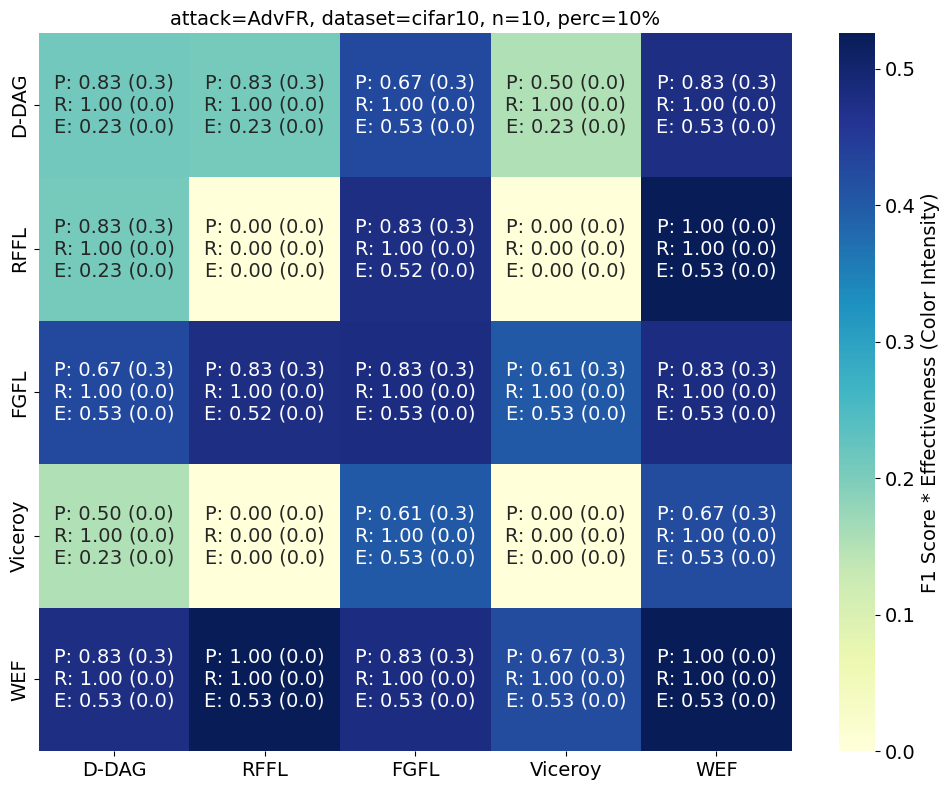

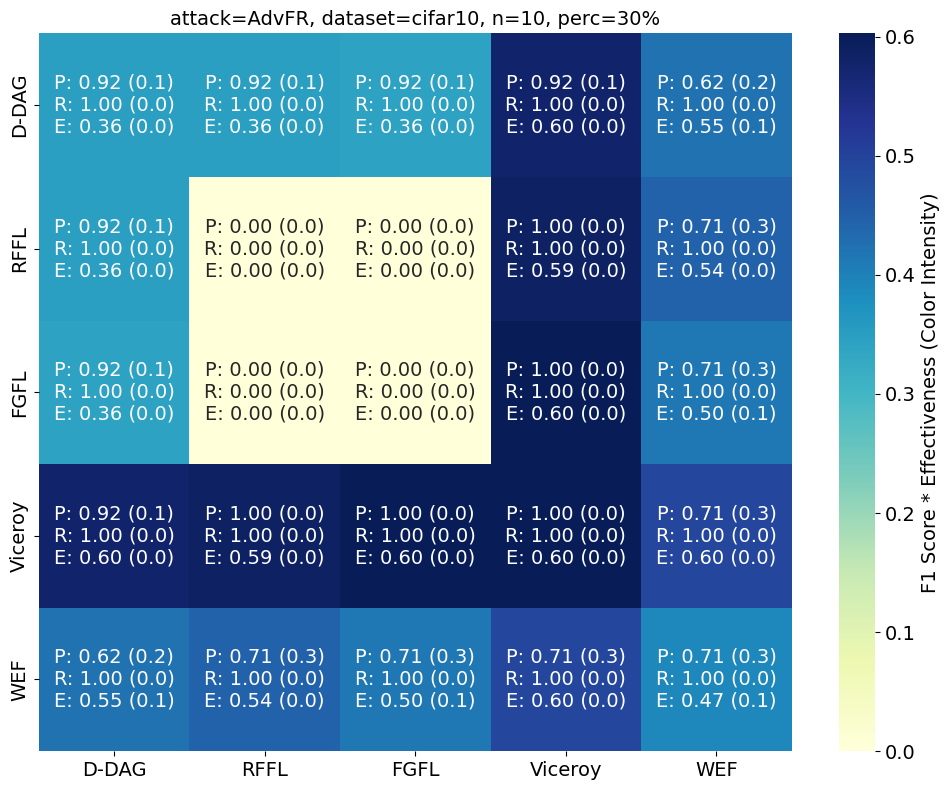

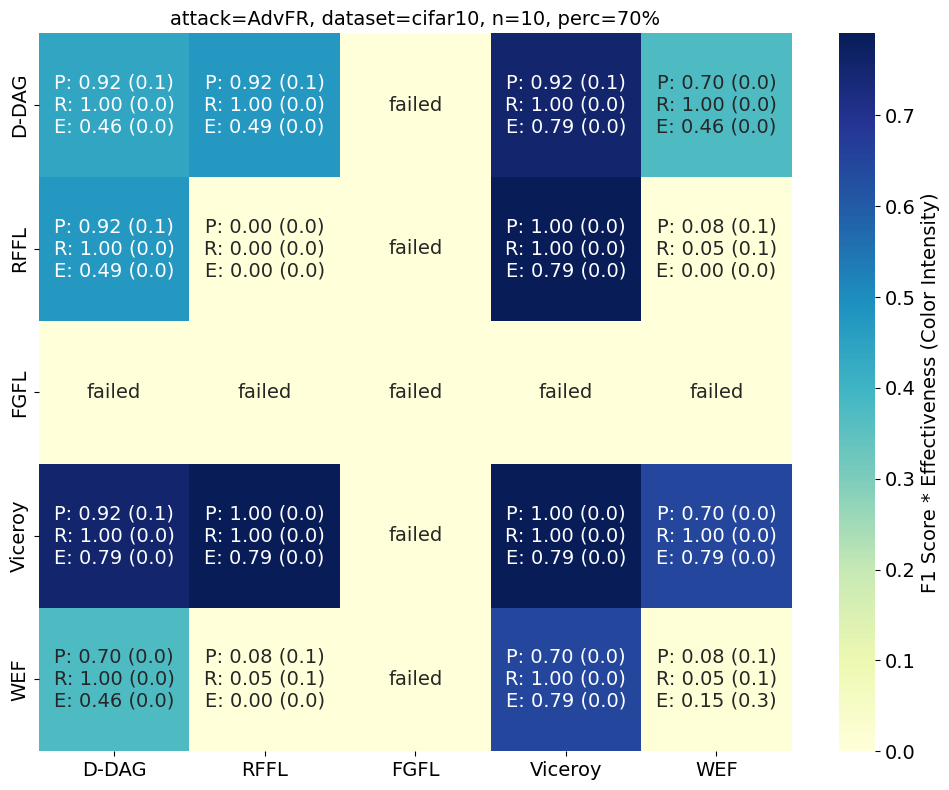

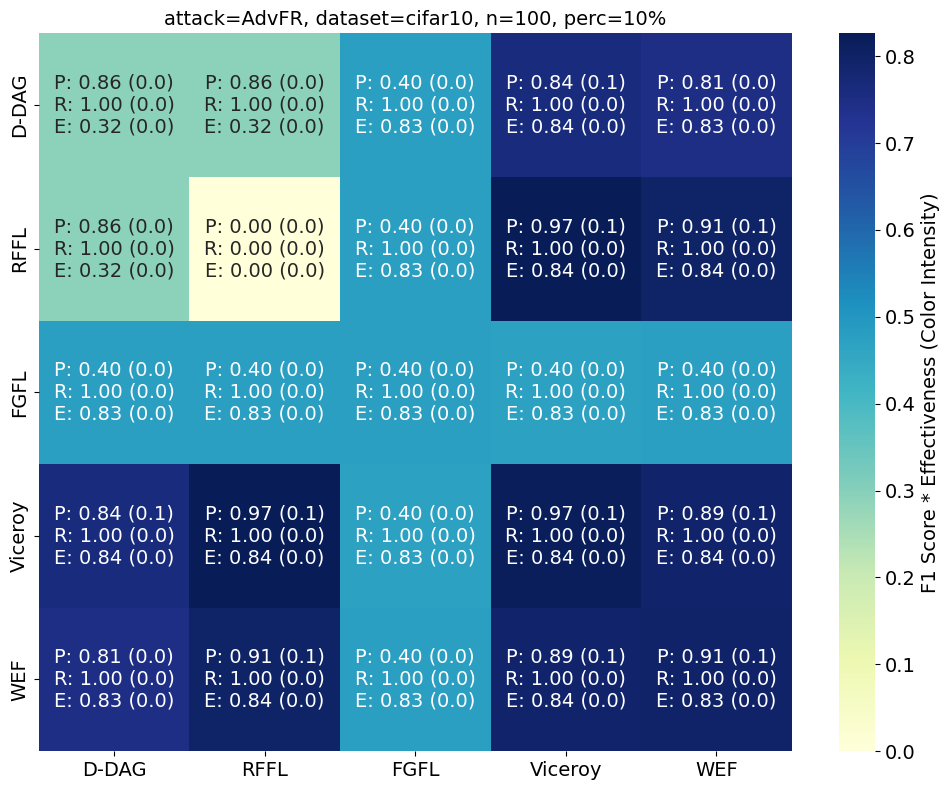

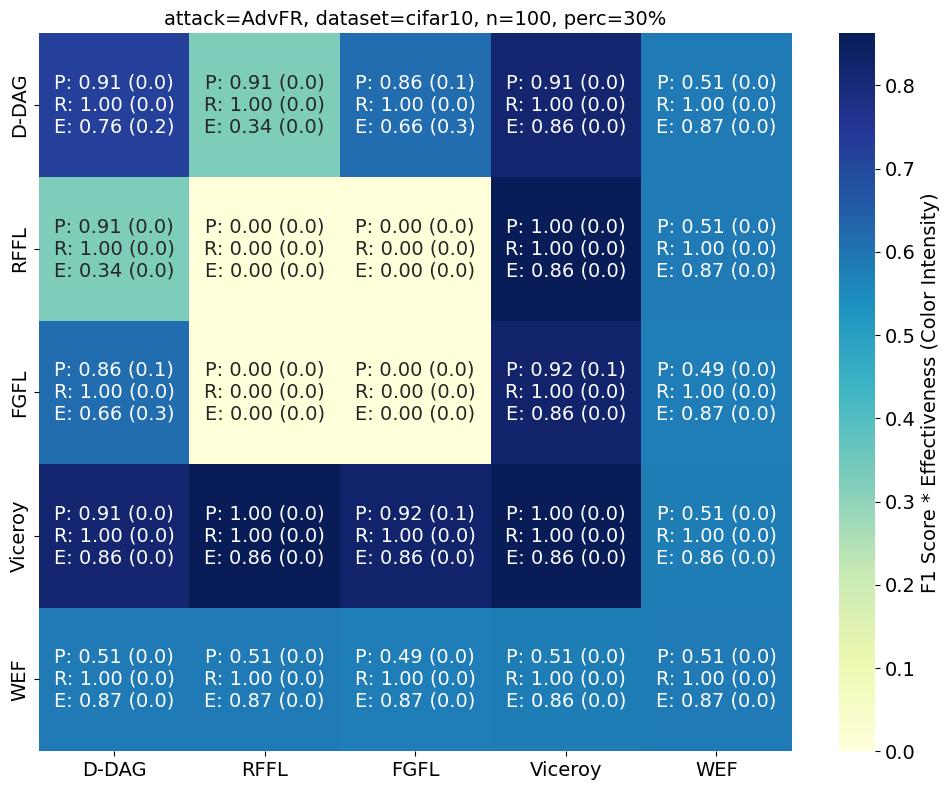

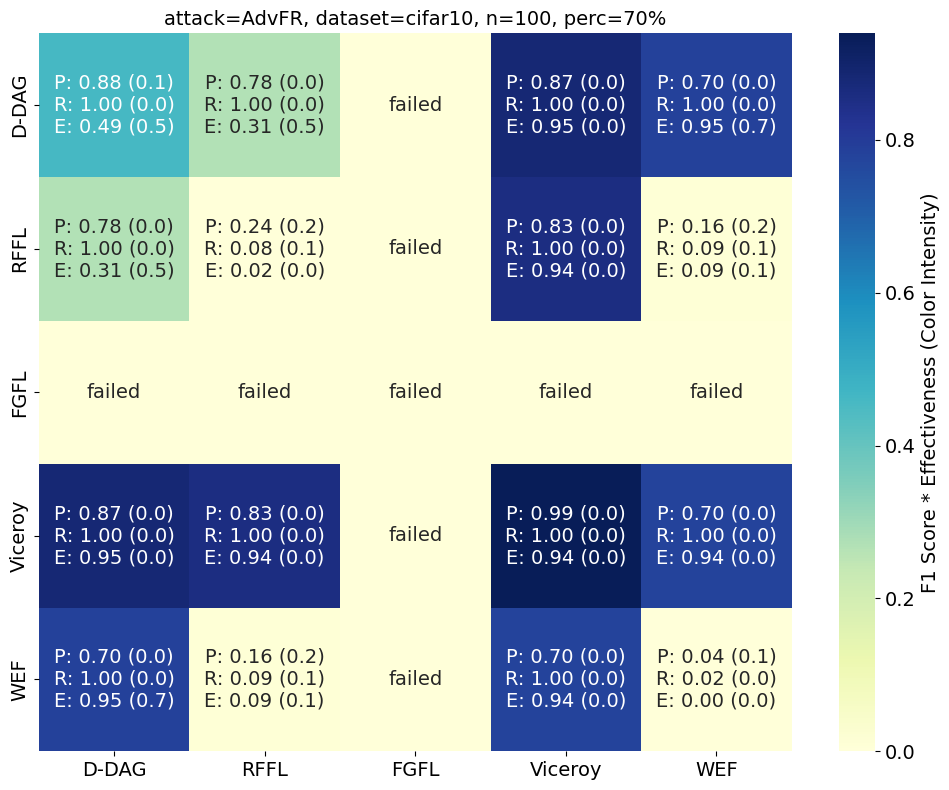

In [29]:
datasets = [DatasetNames.mnist, DatasetNames.cifar10]
n_clients = [10, 100]
perc_malicious = [10, 30, 70]
attack = AttackNames.advanced_free_rider_attack

# Get separate confusion matrices
for dat in datasets:
    for n_c in n_clients:
        for perc in perc_malicious:
            generate_confusion_matrix([dat], [n_c], [perc], [attack])

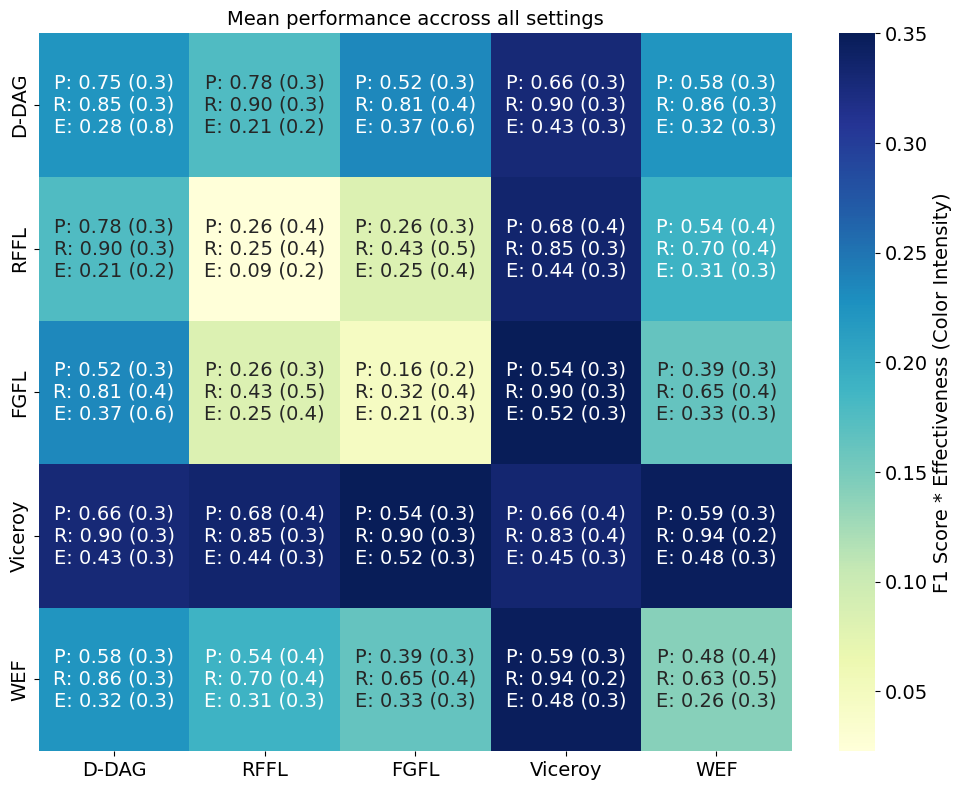

In [30]:
datasets = [DatasetNames.mnist, DatasetNames.cifar10]
n_clients = [10, 100]
perc_malicious = [10, 30, 70]
attacks = [AttackNames.random_weights_attack, AttackNames.advanced_delta_weights_attack, AttackNames.advanced_free_rider_attack, AttackNames.adaptive_attack]
generate_confusion_matrix(datasets, n_clients, perc_malicious, attacks, isSingleSetting=False)